# BioSound Tutorial 6.  Comparing the mean MPS of each baby in B vs D. 

## Step 1. Loading all the dependencies.  
### numpy, matplotlib and soundsig should have been installed when you installed soundsig.  You might have to also install pandas, pickle and sklearn.

In [39]:
# Import math, pandas and soundsig libraries
import numpy as np
import pandas as pd
from soundsig.sound import BioSound 
from soundsig.discriminate import discriminatePlot
import pickle
from sklearn.decomposition import PCA
from scipy.stats.mstats import zscore
from scipy.stats import ttest_1samp 
from scipy.stats import f
from scipy.stats import pearsonr

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.transforms import Bbox
from matplotlib import colormaps


import os


## Step 2. Specifying the location of the sound files in BioSound format (h5 files).

YOU WILL WANT TO CHANGE TO FOLLOWING CODE TO POINT TO THE RIGHT PLACE  
You will also want to change the location for storing the pandas table.  
Note that you might want to also change the name of the h5 file that stores all of the spectrograms.

In [40]:
# Go to the folder that has the h5 files corresponding to the BioSound objects.
os.chdir('/Users/frederictheunissen/Google Drive/My Drive/PowerData/PleursBebe/cry_sequences_22babies/h5files')


# This is where you want to store eps of figures that will be generated.
figdir = '/Users/frederictheunissen/Google Drive/My Drive/PowerData/PleursBebe/'

# Read csv file with baby gender.
babyInfo = pd.read_csv('/Users/frederictheunissen/Google Drive/My Drive/PowerData/PleursBebe/Banque_data_tous.csv', 
                       delimiter= ';', index_col = 0)

subjectInfo = pd.read_csv('/Users/frederictheunissen/Google Drive/My Drive/PowerData/PleursBebe/success_2tests.csv', 
                       delimiter= ';', index_col = False, decimal = ',')


## Step 3. Looping through a set of bioSoundObjects to extract the modulation power spectrum and storing them into a Pandas Data Frame.

#### Part 1. Extract MPS (or Spectrograms); normalize if desired; and compress by PCA

Here we are doing the PC to store the data efficiently.  Unless you have a ton of data the classifier will only use a small number of these anyway.  The first PCA is to reduce from the ~25000 (for these data) space of spectrogram to a space of 50.  As you will see this is able to capture almost 90% of the variance.

In [41]:
# Read first one to allocate space for np array and count the other ones (lazy code...)

count = 0
for fname in os.listdir('.'):
    if fname.endswith('.h5'):
        if (count == 0):
            myBioSound = BioSound()
            myBioSound.readh5(fname)        
        count += 1

# Cut the mps to central region 
wfInd = np.argwhere(myBioSound.wf >= 0).flatten()
wtInd = np.argwhere((myBioSound.wt >= -50) & (myBioSound.wt <=50) ).flatten()

shapeDesired = (len(wfInd), len(wtInd))

X = np.zeros((count, shapeDesired[0]*shapeDesired[1]))
print('Allocated space for all MPS') 

wfi, wtj = np.meshgrid(wfInd, wtInd, indexing = 'ij')


Allocated space for all MPS


In [42]:
wf0 = np.argwhere(myBioSound.wf == 0).flatten()[0]
wt0 = np.argwhere(myBioSound.wt == 0).flatten()[0]

In [43]:
# Loop again to extract the central section of the MPS and store the in X 

# Looping again through all the files
count = 0
dcVals = []
sumVals = []
babyIDs = []
sexIDs = []
condIDs = []
for fname in os.listdir('.'):
    if fname.endswith('.h5'):
        
        # Allocate object and read data
        myBioSound = BioSound()
        myBioSound.readh5(fname)
        
        X[count,:] = 10*np.log10(np.ravel(myBioSound.mps[wfi, wtj]))
        
        # These are our three identifiers - the emitter (baby), the sex and the type of cry
        baby = myBioSound.emitter.tobytes().decode('UTF-8')
        sex = babyInfo.loc[baby]['sex']
        condition = myBioSound.type.tobytes().decode('UTF-8')
        babyIDs.append(baby)
        sexIDs.append(sex)
        condIDs.append(condition)
        
        dcval = np.log(myBioSound.mps[wf0, wt0])
        sumval = np.sum(X[count,:])
        dcVals.append(dcval)
        sumVals.append(sumval)
        
        count +=1
            
print('Read %d files and mps' % count)
print('DC: Mean = ', np.mean(dcVals), 'SD = ', np.std(dcVals), 'CV = ', np.std(dcVals)/np.mean(dcVals))
print('Sum: Mean = ', np.mean(sumVals), 'SD = ', np.std(sumVals), 'CV = ', np.std(sumVals)/np.mean(sumVals))




Read 286 files and mps
DC: Mean =  8.819961876900114 SD =  0.4842324367647433 CV =  0.05490187412634632
Sum: Mean =  -74833.13509248276 SD =  8489.741611581978 CV =  -0.11344896349845433


In [44]:
# Make list into np arrays
babyIDs = np.array(babyIDs)
condIDs = np.array(condIDs)

----------------------- AMJ ---------------------


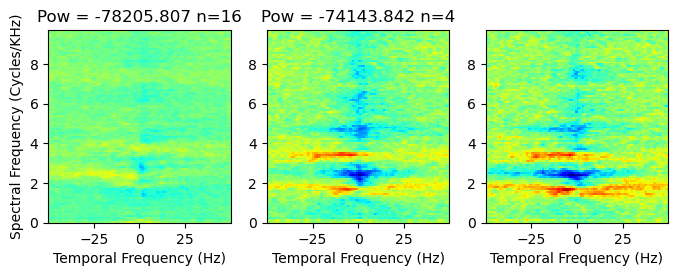

----------------------- ASE ---------------------


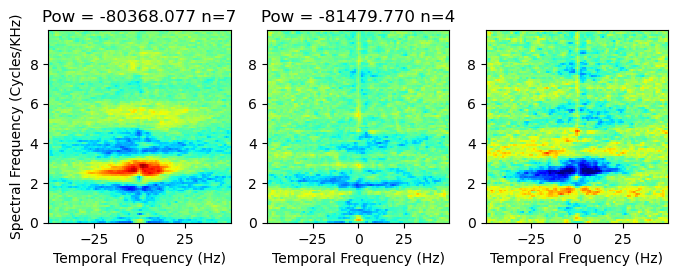

----------------------- AUP ---------------------


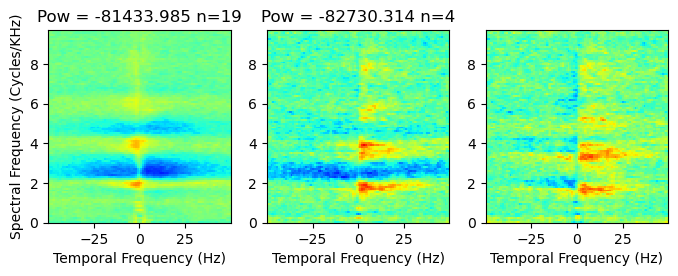

----------------------- BEL ---------------------


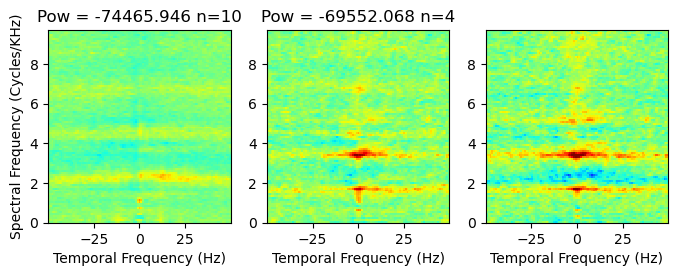

----------------------- BEV ---------------------


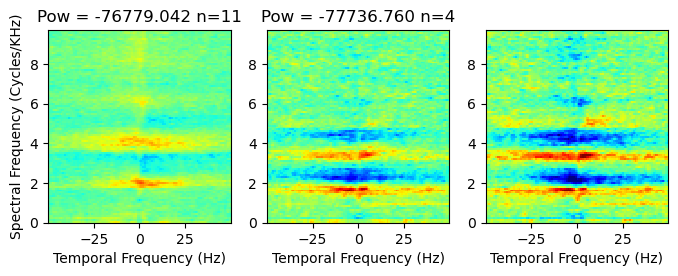

----------------------- CAA ---------------------


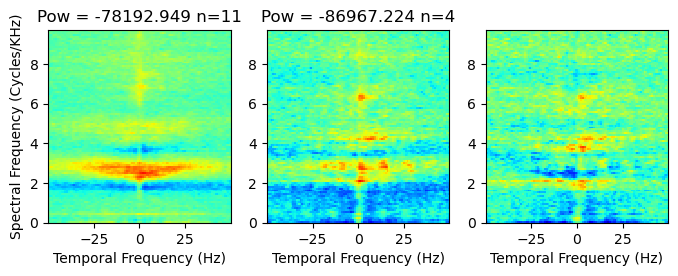

----------------------- CAE ---------------------


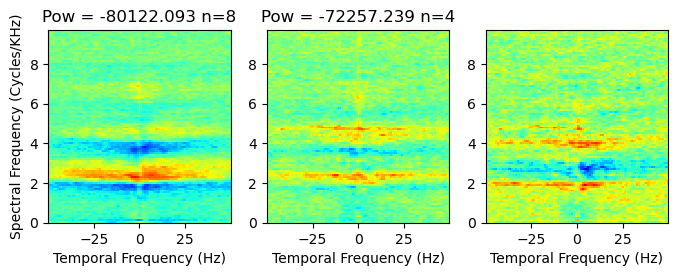

----------------------- CHE ---------------------


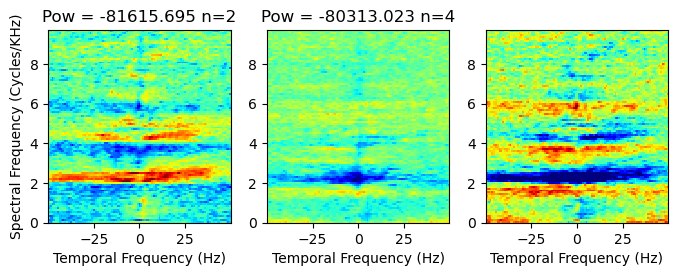

----------------------- CHM ---------------------


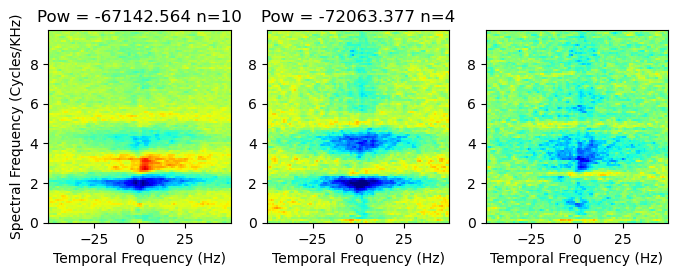

----------------------- DUH ---------------------


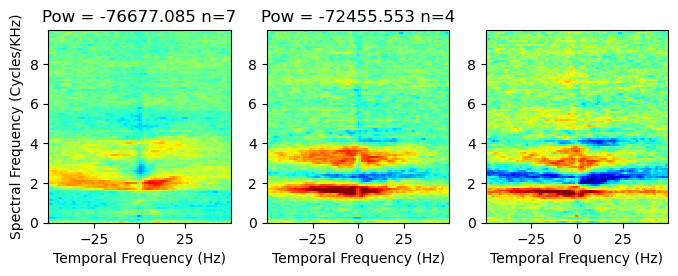

----------------------- FAE ---------------------


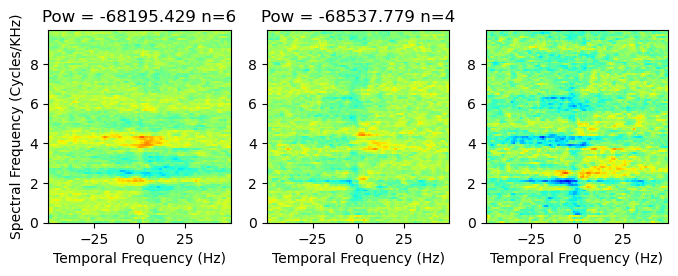

----------------------- GAP ---------------------


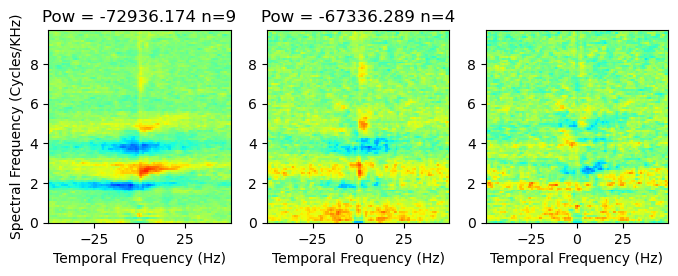

----------------------- GRG ---------------------


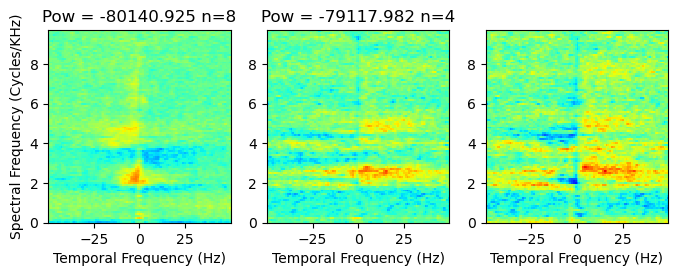

----------------------- JOL ---------------------


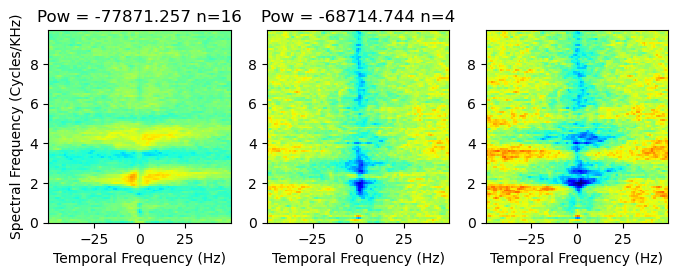

----------------------- JOM ---------------------


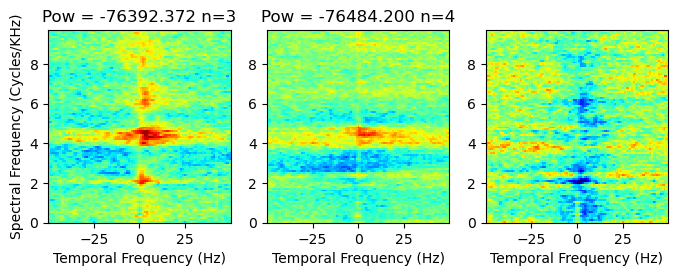

----------------------- MAJ ---------------------


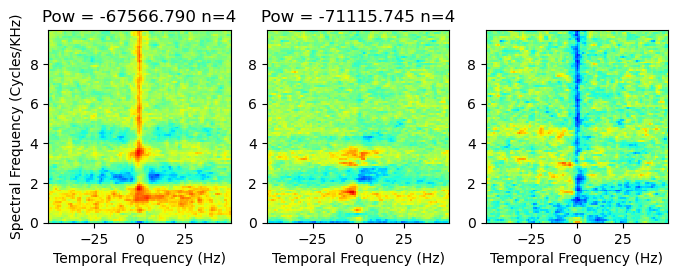

----------------------- MIS ---------------------


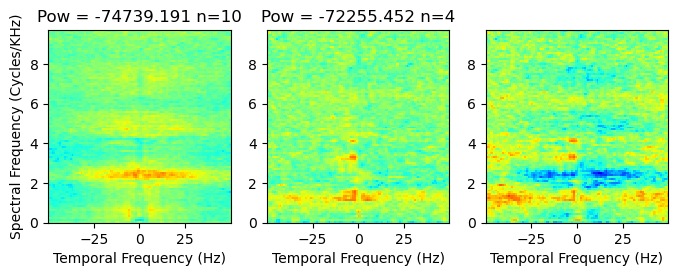

----------------------- RAP ---------------------


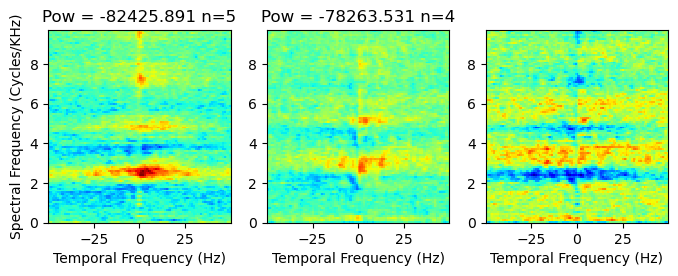

----------------------- RAR ---------------------


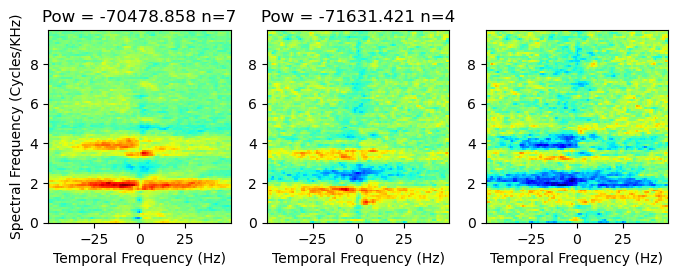

----------------------- ROM ---------------------


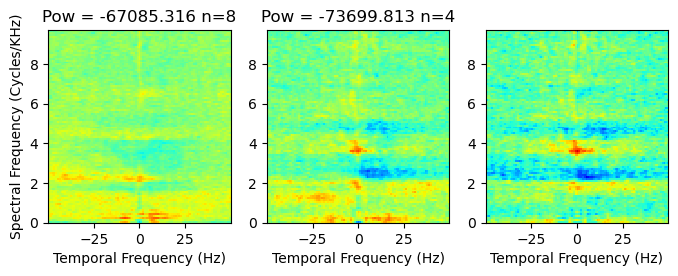

----------------------- VIC ---------------------


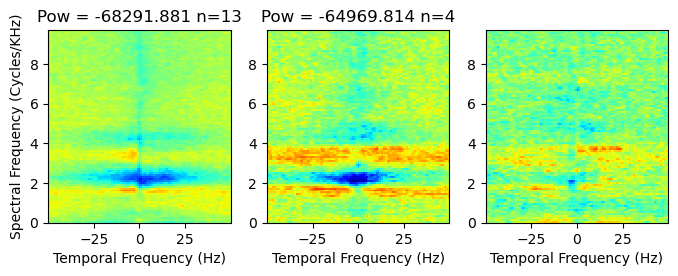

----------------------- ZEP ---------------------


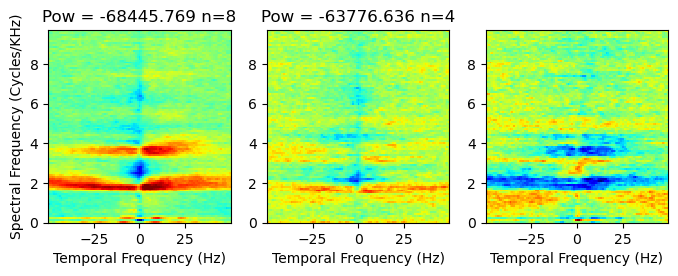

In [45]:
# Make list into np arrays
babyIDs = np.array(babyIDs)
conbIDs = np.array(condIDs)

# Range of MPS
ex = (myBioSound.wt[wtInd[0]], myBioSound.wt[wtInd[-1]], myBioSound.wf[wfInd[0]]*1e3, myBioSound.wf[wfInd[-1]]*1e3)

# Take the average of the MPS
meanX = np.mean(X, axis=0)

# Separate into bath and vax
bathInd = np.argwhere(condIDs == 'B').flatten()
vaxInd = np.argwhere(condIDs == 'D').flatten()

# Loop through babies
babies = np.unique(babyIDs)
nBabies = babies.shape[0]
bathMPS = np.zeros((nBabies, shapeDesired[0]*shapeDesired[1]))
vaxMPS = np.zeros((nBabies, shapeDesired[0]*shapeDesired[1]))


for ibaby, baby in enumerate(babies):
    babyInd = np.argwhere(babyIDs == baby).flatten()

    babyBathInd = np.intersect1d(babyInd, bathInd)
    meanBabyBath = np.mean(X[babyBathInd,:], axis=0)
    babyBathMPS = meanBabyBath - meanX
    bathMPS[ibaby,:] = babyBathMPS
    
    babyVaxInd = np.intersect1d(babyInd, vaxInd)
    meanBabyVax = np.mean(X[babyVaxInd,:], axis=0)
    babyVaxMPS = meanBabyVax - meanX
    vaxMPS[ibaby,:] = babyVaxMPS
    
    print('-----------------------', baby, '---------------------')
    plt.figure(figsize=(8,2.5))
    plt.clf()
    cmap = plt.get_cmap('jet')
    plt.subplot(1,3,1)
    MPS1 = np.reshape(babyBathMPS, (shapeDesired[0],shapeDesired[1]))
    plt.imshow(MPS1, interpolation='nearest', aspect='auto', origin='lower', cmap=cmap, extent=ex)
    plt.ylabel('Spectral Frequency (Cycles/KHz)')
    plt.xlabel('Temporal Frequency (Hz)')
    plt.title('Pow = %.3f n=%d' % (np.sum(meanBabyBath), len(babyBathInd)))
    plt.clim(-10, 10)
    plt.subplot(1,3,2)
    MPS2 = np.reshape(babyVaxMPS, (shapeDesired[0],shapeDesired[1]))
    plt.imshow(MPS2, interpolation='nearest', aspect='auto', origin='lower', cmap=cmap, extent=ex)
    plt.xlabel('Temporal Frequency (Hz)')
    plt.title('Pow = %.3f n=%d' % (np.sum(meanBabyVax), len(babyVaxInd)))
    plt.clim(-10, 10)
    plt.subplot(1,3,3)
    plt.imshow(MPS2-MPS1, interpolation='nearest', aspect='auto', origin='lower', cmap=cmap, extent=ex)
    plt.xlabel('Temporal Frequency (Hz)')
    plt.clim(-10, 10)
    
    
    if (baby == 'ASE'):
        plt.savefig('/Users/frederictheunissen/Google Drive/My Drive/PowerData/PleursBebe/ASE_MPS.eps')
    plt.show()
    

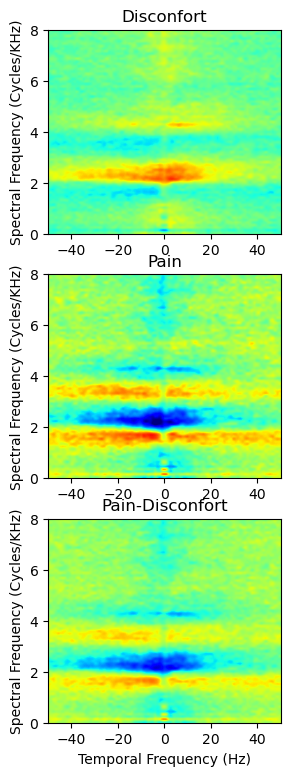

In [46]:
# Plot the average difference in MPS

fig, ax = plt.subplots(3,1, dpi = 100, figsize=(3,9))
cmap = plt.get_cmap('jet')

MPS = np.reshape(np.mean(bathMPS, axis=0), (shapeDesired[0],shapeDesired[1]))
ax[0].imshow(MPS, interpolation='spline16', aspect='auto', origin='lower', cmap=cmap, extent=ex, clim=(-2.5,2.5))
ax[0].set_ylabel('Spectral Frequency (Cycles/KHz)')
ax[0].set_ylim((0,8))
# plt.xlabel('Temporal Frequency (Hz)')
# plt.clim(-5, 5)
# plt.colorbar()
ax[0].set_title('Disconfort')

MPS = np.reshape(np.mean(vaxMPS, axis=0), (shapeDesired[0],shapeDesired[1]))
ax[1].imshow(MPS, interpolation='spline16', aspect='auto', origin='lower', cmap=cmap, extent=ex, clim=(-2.5,2.5))
ax[1].set_ylabel('Spectral Frequency (Cycles/KHz)')
ax[1].set_ylim((0,8))
# plt.xlabel('Temporal Frequency (Hz)')
# plt.colorbar()
ax[1].set_title('Pain')


diffMPS = np.mean(vaxMPS-bathMPS, axis = 0)
MPS = np.reshape(diffMPS, (shapeDesired[0],shapeDesired[1]))
ax[2].imshow(MPS, interpolation='spline16', aspect='auto', origin='lower', cmap=cmap, extent=ex, clim=(-5,5))
ax[2].set_ylabel('Spectral Frequency (Cycles/KHz)')
ax[2].set_xlabel('Temporal Frequency (Hz)')
ax[2].set_ylim((0,8))
# plt.colorbar()
ax[2].set_title('Pain-Disconfort')

plt.savefig('/Users/frederictheunissen/Google Drive/My Drive/PowerData/PleursBebe/VaxBathMPS.eps')



In [47]:
# Normalize the vector so that it can be used as a basis
diffMPS = diffMPS/np.linalg.norm(diffMPS)

In [48]:
# Between ID variance in each group using all dimensions
bathMPSMean = np.mean(bathMPS, axis = 0)
vaxMPSMean = np.mean(vaxMPS, axis = 0)

bathDists = []
vaxDists = []
for ibaby, baby in enumerate(babies):
    bathDists.append(np.sum((bathMPS[ibaby,:]-bathMPSMean)**2))
    vaxDists.append(np.sum((vaxMPS[ibaby,:]-vaxMPSMean)**2))

print("Bath Distantce to Mean: %.2f +- %.3f (2SE)" % (np.mean(bathDists), 2.0*np.std(bathDists)/np.sqrt(nBabies)))
print("Vax Distance to Mean: %.2f +- %.3f (2SE)" % (np.mean(vaxDists), 2.0*np.std(vaxDists)/np.sqrt(nBabies)))

# These distances are similar but certainly corrupted by noise

Bath Distantce to Mean: 27512.57 +- 6609.918 (2SE)
Vax Distance to Mean: 27147.29 +- 5036.565 (2SE)


In [49]:
# Do a PCA along the dimension corresponding to variance within bathMPS
pcaBath = PCA(n_components=2)
bathMPS_PC12 = pcaBath.fit_transform(bathMPS) 
vaxMPS_PC12 = pcaBath.transform(vaxMPS)

print ('Bath PC Variance explained is %.2f%%' % (sum(pcaBath.explained_variance_ratio_)*100.0))

# Find the coefficients along the difference between the two groups
bathMPS_DFA1 = np.dot(bathMPS, diffMPS)
vaxMPS_DFA1 = np.dot(vaxMPS, diffMPS)


Bath PC Variance explained is 54.90%


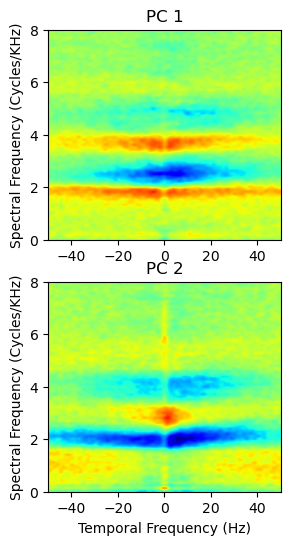

In [50]:
# Display the  first two PCAs

fig, ax = plt.subplots(2,1, dpi = 100, figsize=(3,6))
cmap = plt.get_cmap('jet')
flipval = [-1, 1]
for ipc in range(2):
    MPS = np.reshape(pcaBath.components_[ipc]*flipval[ipc], (shapeDesired[0],shapeDesired[1]))
    ax[ipc].imshow(MPS, interpolation='spline16', aspect='auto', origin='lower', cmap=cmap, extent=ex, clim=(-0.05,0.05))
    ax[ipc].set_ylabel('Spectral Frequency (Cycles/KHz)')
    if ipc == 1:
        ax[ipc].set_xlabel('Temporal Frequency (Hz)')
    ax[ipc].set_ylim((0,8))
    ax[ipc].set_title('PC %d' % (ipc+1))

plt.savefig('/Users/frederictheunissen/Google Drive/My Drive/PowerData/PleursBebe/BathPC1_2.eps')



Bath 2D Distance to Mean: 107.97 +- 25.035 (2SE)
Vax 2D Distance to Mean: 76.06 +- 18.665 (2SE)
Difference 31.91  t(21)=2.251 p=0.0352


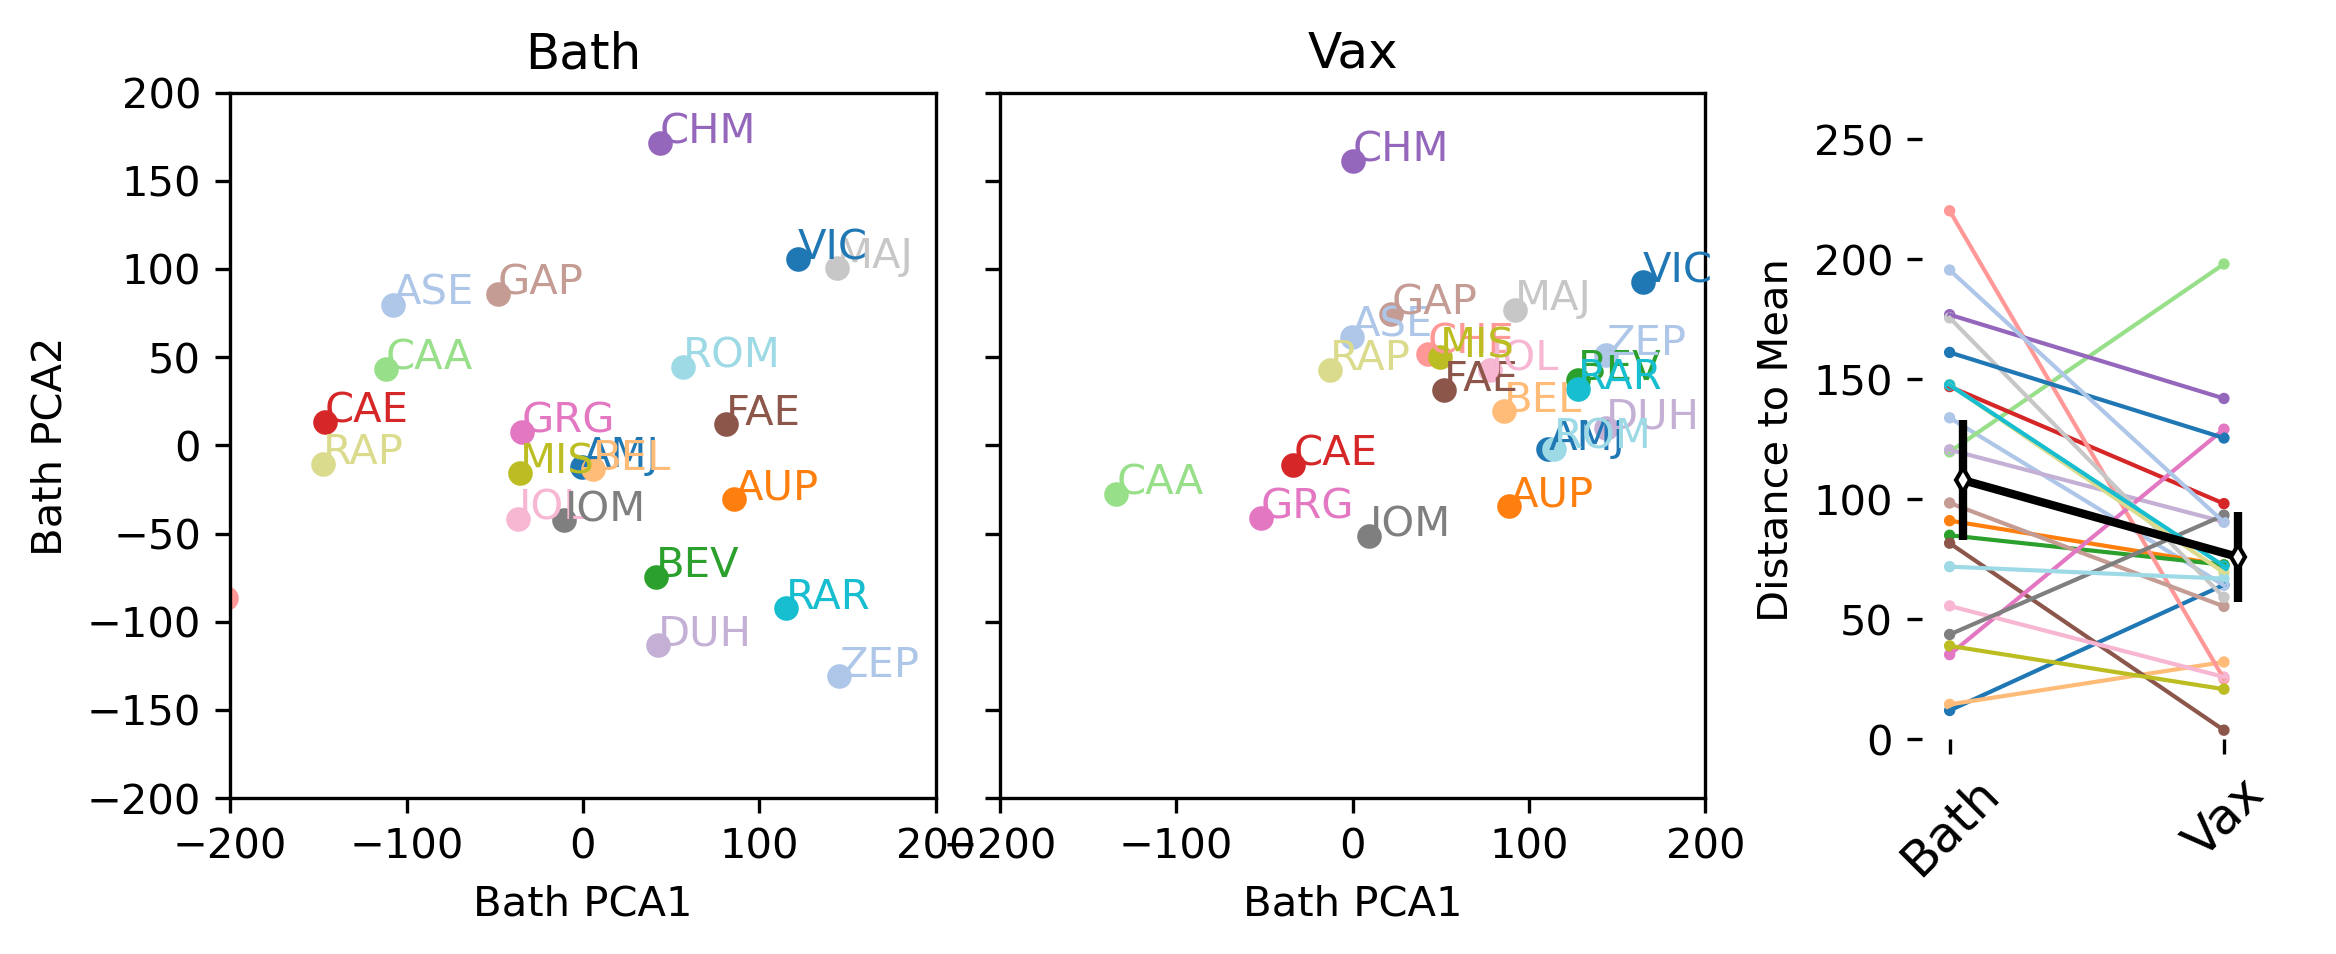

In [51]:
# Loop through babies and plot data 
babies = np.unique(babyIDs)

cmap = colormaps['tab20']

fig = plt.figure(figsize=(8,4), dpi=300)
gs = GridSpec(1, 5, figure=fig)
ax0 = fig.add_subplot(gs[0, 0:2])
ax1 = fig.add_subplot(gs[0, 2:4])
ax3 = fig.add_subplot(gs[0, 4])
colorVals = []


for ibaby, baby in enumerate(babies):
    
    ax0.scatter(-bathMPS_PC12[ibaby,0], bathMPS_PC12[ibaby,1],
              s = 24,
              color=cmap.colors[ibaby%20])
    ax0.annotate(baby, (-bathMPS_PC12[ibaby,0], bathMPS_PC12[ibaby,1]), color=cmap.colors[ibaby%20])
    colorVals.append(cmap.colors[ibaby%20])
    ax0.set_xlabel('Bath PCA1')
    ax0.set_ylabel('Bath PCA2')
    ax0.set_xlim((-200,200))
    ax0.set_ylim((-200,200))
    ax0.set_aspect('equal')
    ax0.set_title('Bath')
    
    ax1.scatter(-vaxMPS_PC12[ibaby,0], vaxMPS_PC12[ibaby,1],
              s = 24,
              color=cmap.colors[ibaby%20])
    ax1.annotate(baby, (-vaxMPS_PC12[ibaby,0], vaxMPS_PC12[ibaby,1]), color=cmap.colors[ibaby%20])
    ax1.set_xlabel('Bath PCA1')
    ax1.set_xlim((-200,200))
    ax1.set_ylim((-200,200))
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    ax1.set_title('Vax')
    # ax[1].set_ylabel('Bath PCA2')
    
# Repeat ID variance in each group for first 2 PCs
bathMPSMean = np.mean(bathMPS_PC12, axis = 0)
vaxMPSMean = np.mean(vaxMPS_PC12, axis = 0)

bathDists = []
vaxDists = []
for ibaby, baby in enumerate(babies):
    bathDists.append(np.sqrt(np.sum((bathMPS_PC12[ibaby,:]-bathMPSMean)**2)))
    vaxDists.append(np.sqrt(np.sum((vaxMPS_PC12[ibaby,:]-vaxMPSMean)**2)))

print("Bath 2D Distance to Mean: %.2f +- %.3f (2SE)" % (np.mean(bathDists), 2.0*np.std(bathDists)/np.sqrt(nBabies)))
print("Vax 2D Distance to Mean: %.2f +- %.3f (2SE)" % (np.mean(vaxDists), 2.0*np.std(vaxDists)/np.sqrt(nBabies)))
ttestResult = ttest_1samp(np.array(bathDists)-np.array(vaxDists), 0.0)
print("Difference %.2f  t(%d)=%.3f p=%.4f" % (np.mean(bathDists)- np.mean(vaxDists), 
                                                          len(bathDists)-1,
                                                          ttestResult.statistic,
                                                          ttestResult.pvalue) )

scores_1 = bathDists
scores_2 = vaxDists
    
mean_1 = np.mean(scores_1)
mean_2 = np.mean(scores_2)

sem_1 = np.std(scores_1) / np.sqrt(len(scores_1))
sem_2 = np.std(scores_2) / np.sqrt(len(scores_2))

for ibaby, baby in enumerate(babies):
    ax3.plot([0, 1], np.array([scores_1[ibaby], scores_2[ibaby]]), alpha=1, linewidth=1, color=colorVals[ibaby])

    ax3.scatter(0, scores_1[ibaby], s=3, linewidth=1, alpha=1, facecolor="none", edgecolor=colorVals[ibaby])
    ax3.scatter(1, scores_2[ibaby], s=3, linewidth=1, alpha=1, facecolor="none", edgecolor=colorVals[ibaby])

ax3.errorbar(
    [0.05, 1.05], 
    [mean_1, mean_2], 
    2 * np.array([sem_1, sem_2]),
    linewidth=2, markersize=4, markerfacecolor="white", color='black', marker="d")

ax3.set_ylabel('Distance to Mean')
ax3.set_xticks(
        [0, 1],
        ["Bath", "Vax"],
        rotation=45,
        fontsize=12)

ax3.set_frame_on(False)
ax3.set_xlim((-0.1, 1.3))
ax3.set_ylim((0, 250))
ax3.set_position(Bbox([[0.83, 0.25], [0.99, 0.75]]))
#ax3.set_position([0.84, 0.2, 0.2, 0.58])
#ax3s.margins(0.5, 0.5)

plt.savefig('/Users/frederictheunissen/Google Drive/My Drive/PowerData/PleursBebe/BathVaxBathPCA.eps')

plt.show()

In [52]:
# PCA along the dimension corresponding to variance within VaxMPS
pcaVax = PCA(n_components=2)
vaxMPS_PC12Vax = pcaVax.fit_transform(vaxMPS) 
bathMPS_PC12Vax = pcaVax.transform(bathMPS)


Bath 2D Distance to Mean: 82.98 +- 17.348 (2SE)
Vax 2D Distance to Mean: 97.75 +- 21.290 (2SE)
Difference -14.77  t(21)=-1.141 p=0.2666


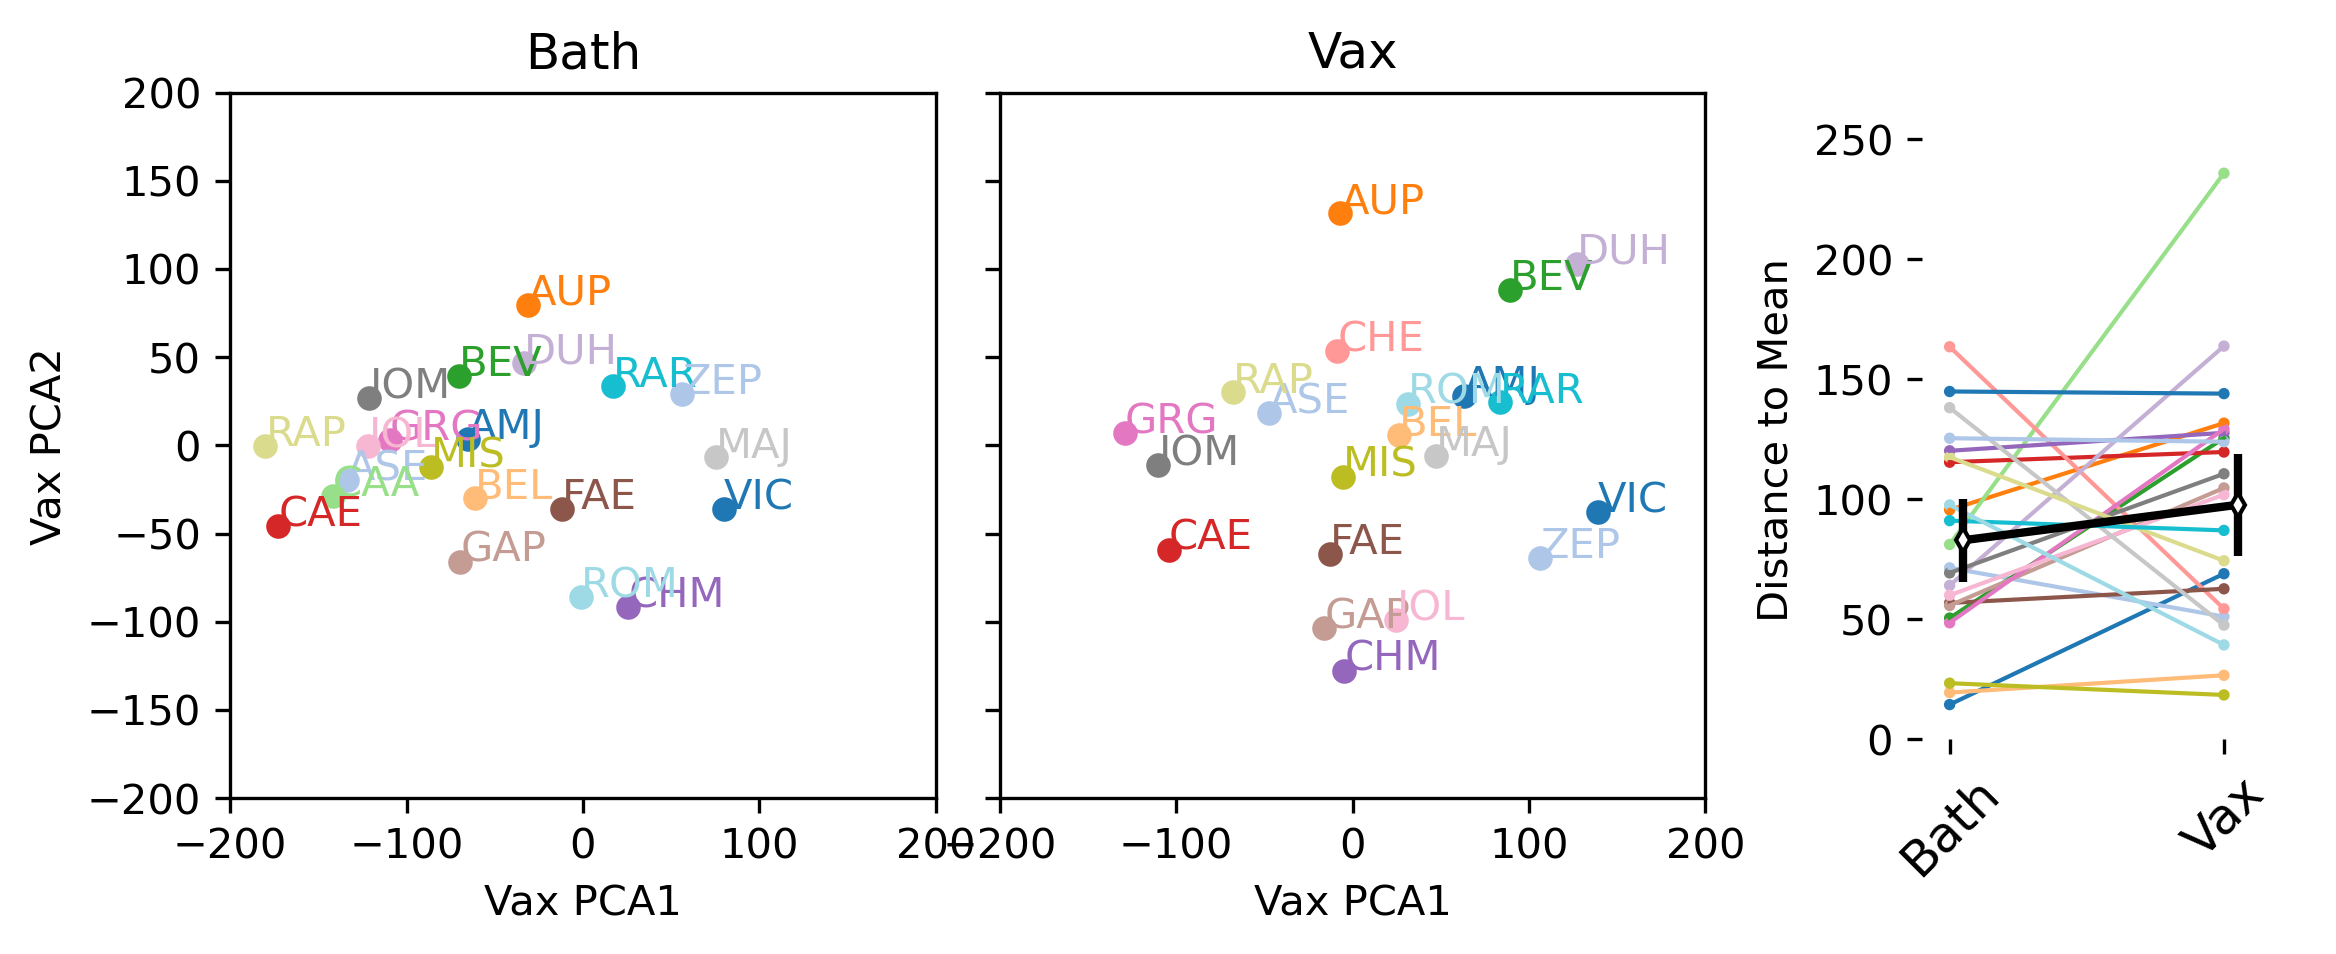

In [53]:
# Repeat with vaxPCs
babies = np.unique(babyIDs)

cmap = colormaps['tab20']

fig = plt.figure(figsize=(8,4), dpi=300)
gs = GridSpec(1, 5, figure=fig)
ax0 = fig.add_subplot(gs[0, 0:2])
ax1 = fig.add_subplot(gs[0, 2:4])
ax3 = fig.add_subplot(gs[0, 4])



for ibaby, baby in enumerate(babies):
    
    ax0.scatter(-bathMPS_PC12Vax[ibaby,0], bathMPS_PC12Vax[ibaby,1],
              s = 24,
              color=cmap.colors[ibaby%20])
    ax0.annotate(baby, (-bathMPS_PC12Vax[ibaby,0], bathMPS_PC12Vax[ibaby,1]), color=cmap.colors[ibaby%20])
    ax0.set_xlabel('Vax PCA1')
    ax0.set_ylabel('Vax PCA2')
    ax0.set_xlim((-200,200))
    ax0.set_ylim((-200,200))
    ax0.set_aspect('equal')
    ax0.set_title('Bath')
    
    ax1.scatter(-vaxMPS_PC12Vax[ibaby,0], vaxMPS_PC12Vax[ibaby,1],
              s = 24,
              color=cmap.colors[ibaby%20])
    ax1.annotate(baby, (-vaxMPS_PC12Vax[ibaby,0], vaxMPS_PC12Vax[ibaby,1]), color=cmap.colors[ibaby%20])
    ax1.set_xlabel('Vax PCA1')
    ax1.set_xlim((-200,200))
    ax1.set_ylim((-200,200))
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    ax1.set_title('Vax')
    # ax[1].set_ylabel('Bath PCA2')
    
# Repeat ID variance in each group for first 2 PCs
bathMPSMeanVax = np.mean(bathMPS_PC12Vax, axis = 0)
vaxMPSMeanVax = np.mean(vaxMPS_PC12Vax, axis = 0)

bathDists = []
vaxDists = []
for ibaby, baby in enumerate(babies):
    bathDists.append(np.sqrt(np.sum((bathMPS_PC12Vax[ibaby,:]-bathMPSMeanVax)**2)))
    vaxDists.append(np.sqrt(np.sum((vaxMPS_PC12Vax[ibaby,:]-vaxMPSMeanVax)**2)))

print("Bath 2D Distance to Mean: %.2f +- %.3f (2SE)" % (np.mean(bathDists), 2.0*np.std(bathDists)/np.sqrt(nBabies)))
print("Vax 2D Distance to Mean: %.2f +- %.3f (2SE)" % (np.mean(vaxDists), 2.0*np.std(vaxDists)/np.sqrt(nBabies)))
ttestResult = ttest_1samp(np.array(bathDists)-np.array(vaxDists), 0.0)
print("Difference %.2f  t(%d)=%.3f p=%.4f" % (np.mean(bathDists)- np.mean(vaxDists), 
                                                          len(bathDists)-1,
                                                          ttestResult.statistic,
                                                          ttestResult.pvalue) )

scores_1 = bathDists
scores_2 = vaxDists
    
mean_1 = np.mean(scores_1)
mean_2 = np.mean(scores_2)

sem_1 = np.std(scores_1) / np.sqrt(len(scores_1))
sem_2 = np.std(scores_2) / np.sqrt(len(scores_2))

for ibaby, baby in enumerate(babies):
    ax3.plot([0, 1], np.array([scores_1[ibaby], scores_2[ibaby]]), alpha=1, linewidth=1, color=colorVals[ibaby])

    ax3.scatter(0, scores_1[ibaby], s=3, linewidth=1, alpha=1, facecolor="none", edgecolor=colorVals[ibaby])
    ax3.scatter(1, scores_2[ibaby], s=3, linewidth=1, alpha=1, facecolor="none", edgecolor=colorVals[ibaby])

ax3.errorbar(
    [0.05, 1.05], 
    [mean_1, mean_2], 
    2 * np.array([sem_1, sem_2]),
    linewidth=2, markersize=4, markerfacecolor="white", color='black', marker="d")



ax3.set_ylabel('Distance to Mean')
ax3.set_xticks(
        [0, 1],
        ["Bath", "Vax"],
        rotation=45,
        fontsize=12)

ax3.set_frame_on(False)
ax3.set_xlim((-0.1, 1.3))
ax3.set_ylim((0, 250))
ax3.set_position(Bbox([[0.83, 0.25], [0.99, 0.75]]))
#ax3.set_position([0.84, 0.2, 0.2, 0.58])
#ax3s.margins(0.5, 0.5)
  
plt.savefig('/Users/frederictheunissen/Google Drive/My Drive/PowerData/PleursBebe/BathVaxVaxPCA.eps')

plt.show() 

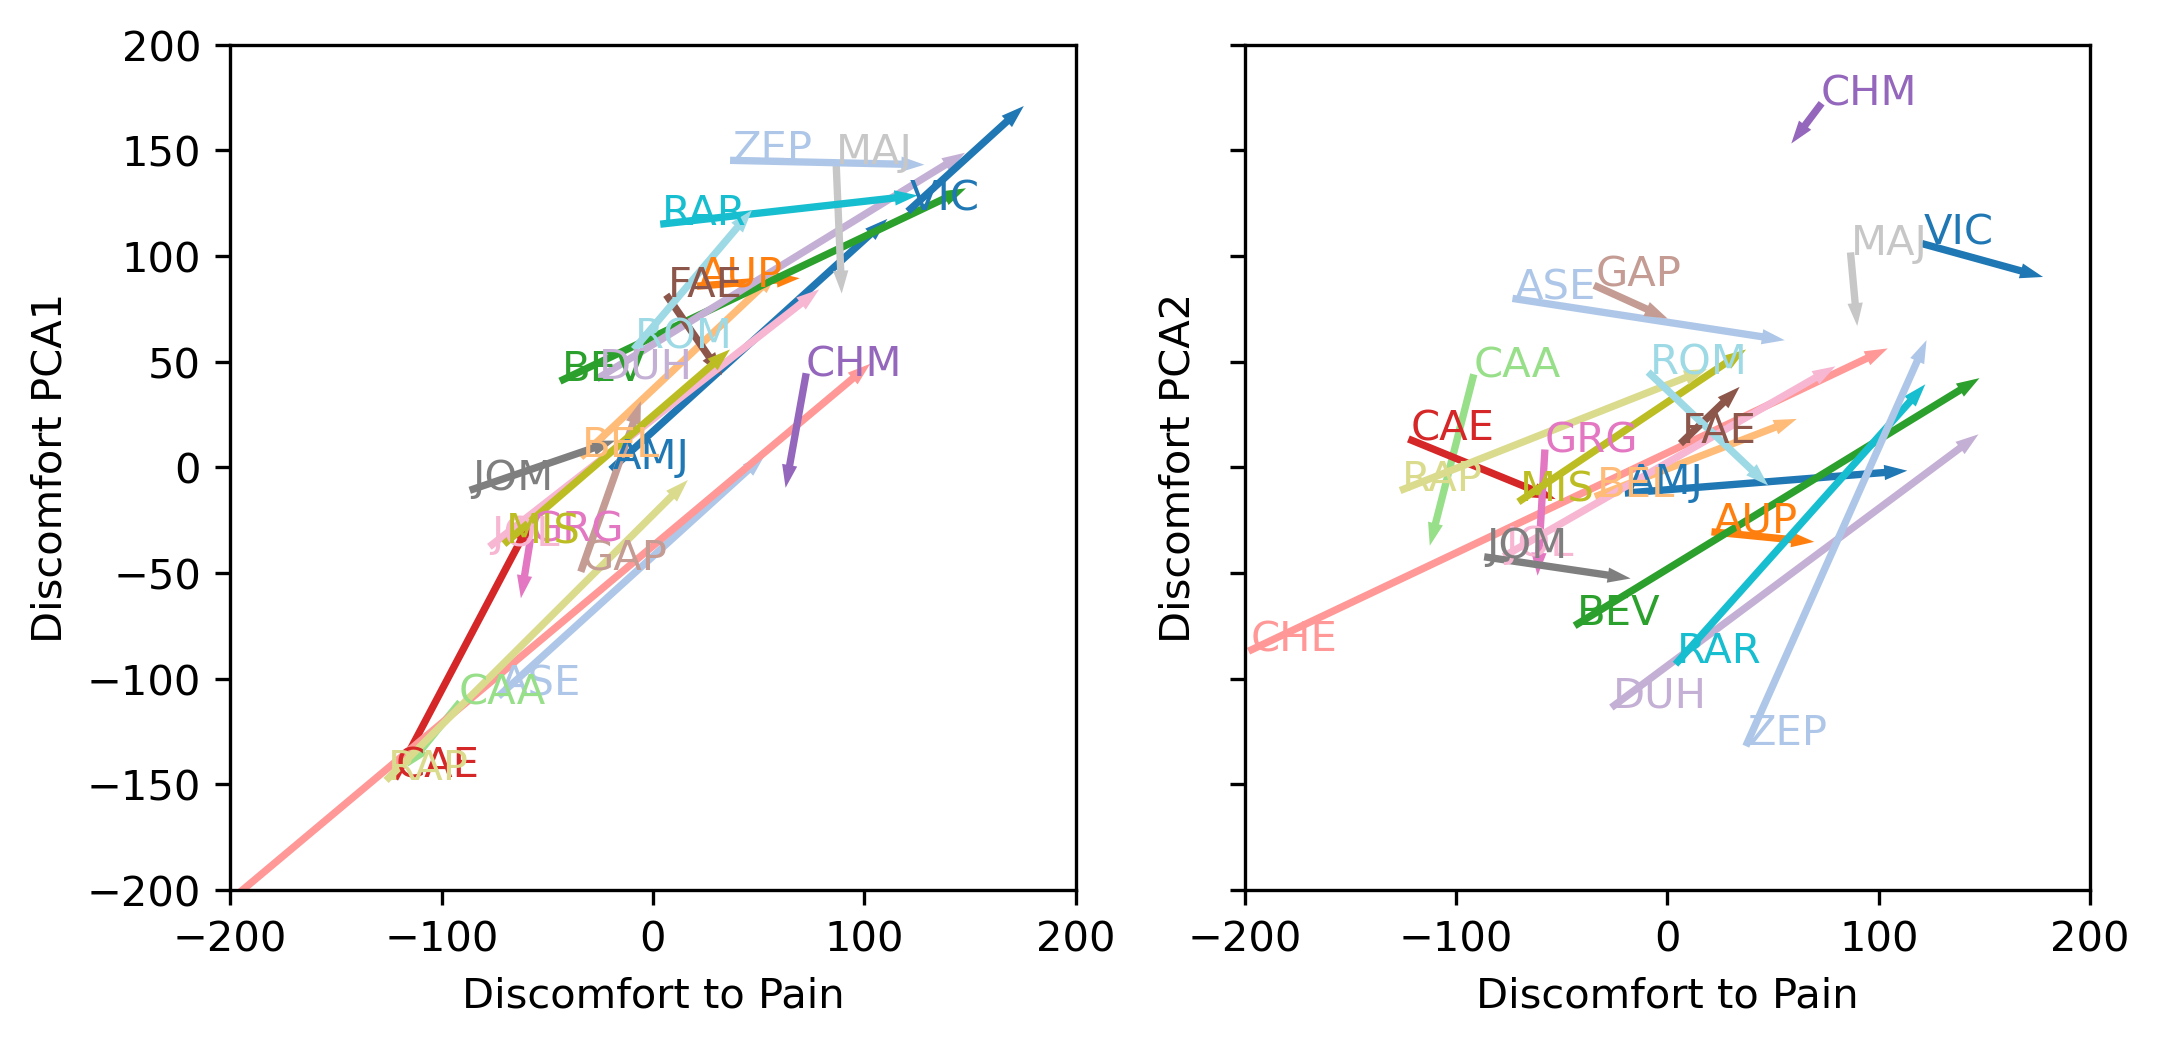

In [54]:
# Loop through babies
babies = np.unique(babyIDs)

cmap = colormaps['tab20']
fig, ax = plt.subplots(1,2, figsize=(8,4), dpi=300 )

for ibaby, baby in enumerate(babies):
    
    ax[0].arrow(bathMPS_DFA1[ibaby], -bathMPS_PC12[ibaby,0],
              vaxMPS_DFA1[ibaby]-bathMPS_DFA1[ibaby], -vaxMPS_PC12[ibaby,0] + bathMPS_PC12[ibaby,0],
              width = 1.5,
              color=cmap.colors[ibaby%20])
    ax[0].annotate(baby, (bathMPS_DFA1[ibaby], -bathMPS_PC12[ibaby,0]), color=cmap.colors[ibaby%20])
    ax[0].set_xlabel('Discomfort to Pain')
    ax[0].set_ylabel('Discomfort PCA1')
    ax[0].set_xlim((-200,200))
    ax[0].set_ylim((-200,200))
    ax[0].set_aspect('equal')
    
    ax[1].arrow(bathMPS_DFA1[ibaby], bathMPS_PC12[ibaby,1],
              vaxMPS_DFA1[ibaby]-bathMPS_DFA1[ibaby], vaxMPS_PC12[ibaby,1] - bathMPS_PC12[ibaby,1],
              width = 1.5,
              color=cmap.colors[ibaby%20])
    ax[1].annotate(baby, (bathMPS_DFA1[ibaby], bathMPS_PC12[ibaby,1]), color=cmap.colors[ibaby%20])
    ax[1].set_xlabel('Discomfort to Pain')
    ax[1].set_ylabel('Discomfort PCA2')
    ax[1].set_xlim((-200,200))
    ax[1].set_ylim((-200,200))
    ax[1].set_yticklabels([])
    ax[1].set_aspect('equal')
    

plt.savefig('/Users/frederictheunissen/Google Drive/My Drive/PowerData/PleursBebe/BathPCA_Bath2VaxDFA.eps')
plt.show()

In [55]:
# Print some statistics for PCs

pcFlip = [-1, 1]

for iPC in range(2):
    print('--------------------- PC %d --------------------' % (iPC+1))
    rPCADFABath = pearsonr(bathMPS_DFA1, pcFlip[iPC]*bathMPS_PC12[:,iPC])
    print('PC%d-(Bath2Vax) for Bath values: r=%.3f p=%.4g' % (iPC+1, rPCADFABath.statistic, rPCADFABath.pvalue))
    rPCADFAVax = pearsonr(vaxMPS_DFA1, pcFlip[iPC]*vaxMPS_PC12[:,iPC])
    print('PCA%d-(Bath2Vax) for Vax values: r=%.3f p=%.4g' % (iPC+1, rPCADFAVax.statistic, rPCADFAVax.pvalue))
    rPCADFADiff = pearsonr(vaxMPS_DFA1-bathMPS_DFA1, pcFlip[iPC]*(vaxMPS_PC12[:,iPC] - bathMPS_PC12[:,iPC]))
    print('PCA%d-(Bath2Vax) for diff values: r=%.3f p=%.4g' % (iPC +1, rPCADFADiff.statistic, rPCADFADiff.pvalue))
    print('Exact Fisher test with Sample size %d' % bathMPS_DFA1.shape[0])

--------------------- PC 1 --------------------
PC1-(Bath2Vax) for Bath values: r=0.899 p=1.295e-08
PCA1-(Bath2Vax) for Vax values: r=0.903 p=8.933e-09
PCA1-(Bath2Vax) for diff values: r=0.857 p=3.438e-07
Exact Fisher test with Sample size 22
--------------------- PC 2 --------------------
PC2-(Bath2Vax) for Bath values: r=0.382 p=0.07913
PCA2-(Bath2Vax) for Vax values: r=0.468 p=0.02791
PCA2-(Bath2Vax) for diff values: r=0.727 p=0.0001248
Exact Fisher test with Sample size 22


In [56]:
# Print some statistics for PC2
rPCADFABath = pearsonr(bathMPS_DFA1, bathMPS_PC12[:,1])
print('PCA1-(Bath2Vax) for Bath values: r=%.3f p=%.4g' % (rPCADFABath.statistic, rPCADFABath.pvalue))
rPCADFAVax = pearsonr(vaxMPS_DFA1, vaxMPS_PC12[:,1])
print('PCA1-(Bath2Vax) for Vax values: r=%.3f p=%.4g' % (rPCADFAVax.statistic, rPCADFAVax.pvalue))
rPCADFADiff = pearsonr(vaxMPS_DFA1-bathMPS_DFA1, vaxMPS_PC12[:,1] - bathMPS_PC12[:,1])
print('PCA1-(Bath2Vax) for diff values: r=%.3f p=%.4g' % (rPCADFADiff.statistic, rPCADFADiff.pvalue))
print('Exact Fisher test with Sample size %d' % bathMPS_DFA1.shape[0])

PCA1-(Bath2Vax) for Bath values: r=0.382 p=0.07913
PCA1-(Bath2Vax) for Vax values: r=0.468 p=0.02791
PCA1-(Bath2Vax) for diff values: r=0.727 p=0.0001248
Exact Fisher test with Sample size 22


In [57]:

vaxBathPC2Dist = []
for ibaby, baby in enumerate(babies):
    vaxBathPC2Dist.append(np.sum((vaxMPS_PC12Vax[ibaby,1]- bathMPS_PC12Vax[ibaby,1])))

ttestResult = ttest_1samp(np.array(vaxBathPC2Dist), 0.0)
print("Difference %.2f  t(%d)=%.3f p=%.4f" % (np.mean(vaxBathPC2Dist), 
                                                          len(vaxBathPC2Dist)-1,
                                                          ttestResult.statistic,
                                                          ttestResult.pvalue) )

Difference 10.48  t(21)=0.895 p=0.3810


In [58]:
bathDistsPC2 = []
vaxDistsPC2 = []
for ibaby, baby in enumerate(babies):
    bathDistsPC2.append(np.sqrt(np.sum((bathMPS_PC12[ibaby,1]-bathMPSMean[1])**2)))
    vaxDistsPC2.append(np.sqrt(np.sum((vaxMPS_PC12[ibaby,1]-vaxMPSMean[1])**2)))

print("Bath 2D Distance to Mean: %.2f +- %.3f (2SE)" % (np.mean(bathDistsPC2), 2.0*np.std(bathDistsPC2)/np.sqrt(nBabies)))
print("Vax 2D Distance to Mean: %.2f +- %.3f (2SE)" % (np.mean(vaxDistsPC2), 2.0*np.std(vaxDistsPC2)/np.sqrt(nBabies)))
ttestResult = ttest_1samp(np.array(bathDistsPC2)-np.array(vaxDistsPC2), 0.0)
print("Difference %.2f  t(%d)=%.3f p=%.4f" % (np.mean(bathDistsPC2)- np.mean(vaxDistsPC2), 
                                                          len(bathDistsPC2)-1,
                                                          ttestResult.statistic,
                                                          ttestResult.pvalue) )

Bath 2D Distance to Mean: 60.34 +- 19.328 (2SE)
Vax 2D Distance to Mean: 37.54 +- 12.991 (2SE)
Difference 22.80  t(21)=2.282 p=0.0330


In [59]:
bathMPSMean

array([-1.29189588e-15, -7.75137530e-15])

In [60]:
vaxMPSMean

array([-55.4147684 ,  30.28591132])

In [72]:
np.unique(subjectInfo['assignedID'])

array(['AMJ', 'AUP', 'BEL', 'BEV', 'CAA', 'CHM', 'JOL', 'MIS', 'VIC'],
      dtype=object)

In [61]:
subjectPerf = []
for ibaby, baby in enumerate(babies):
    subjectPerf.append(np.mean(subjectInfo.loc[subjectInfo['assignedID'] == baby]['success_test1']))

In [62]:
distancePerf = []
dB2V = []

for ibaby, baby in enumerate(babies):
    dBath2Vax = np.sum((vaxMPS[ibaby,:] - bathMPS[ibaby])**2)
    dVax2MeanVax = np.sum((vaxMPS_PC12[ibaby,:] - vaxMPSMean)**2)
    dB2V.append(dBath2Vax*1e-4)
    distancePerf.append(dVax2MeanVax/dBath2Vax)

In [63]:
def linefit(x,y):
    # fit a linear curve an estimate its y-values and their error.
    n = len(x)
    a, b = np.polyfit(x, y, deg=1)
    
    sse = np.sum((y-(a*x+b))**2)
    xmean = np.mean(x)
    ssx = np.sum((x - xmean)**2)
    sst = np.sum((y-np.mean(y))**2)
    syx = np.sqrt(sse/(n-2))
    sy  = np.sqrt(sst/(n-1))
    r2adj = 1. - syx**2/sy**2
    fval = (sst-sse)/syx**2
    pval = 1. - f.cdf(fval, dfn=1, dfd=n-2)

    # Plot the line 
    xsel = np.linspace(x.min(), x.max(), num=100)
    
    y_est = a * xsel + b
    y_err = syx * np.sqrt(1/n + (xsel - xmean)**2 / np.sum((x - xmean)**2))
    
    return xsel, y_est, y_err, r2adj, fval, pval

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


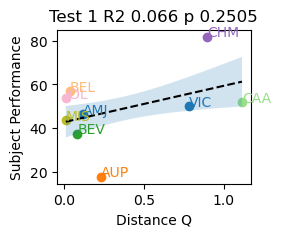

In [64]:
# Correlation avec distance acoustique

fig, ax = plt.subplots(figsize=(2.5,2), dpi = 100)
# ax.scatter(distancePerf, np.array(subjectPerf)*100.0)

for ibaby, baby in enumerate(babies):
    ax.scatter(distancePerf[ibaby], subjectPerf[ibaby]*100.0, color=cmap.colors[ibaby%20])
    ax.annotate(baby, (distancePerf[ibaby], subjectPerf[ibaby]*100.0), color=cmap.colors[ibaby%20])
    
plt.xlabel('Distance Q')
plt.ylabel('Subject Performance')

# fit a linear curve an estimate its y-values and their error without AUP.
# ind = np.argwhere(np.logical_and(np.isnan(subjectPerf)==False, babies != 'AUP')).flatten()
ind = np.argwhere(np.isnan(subjectPerf)==False).flatten()
x = np.array(distancePerf)[ind]
y = np.array(subjectPerf)[ind]*100.0

xsel, y_est, y_err, r2adj, fval, pval = linefit(x,y)

ax.plot(xsel, y_est, '--', color = 'k')
ax.fill_between(xsel, y_est - y_err, y_est + y_err, alpha=0.2)

ax.set(title='Test 1 R2 %.3f p %.4f' % ( r2adj, pval) )
plt.savefig('/Users/frederictheunissen/Google Drive/My Drive/PowerData/PleursBebe/SubjectvsDistanceTest1.eps')

In [65]:
# fit a linear curve an estimate its y-values and their error without AUP.
ind = np.argwhere(np.logical_and(np.isnan(subjectPerf)==False, babies != 'AUP')).flatten()
x = np.array(distancePerf)[ind]
y = np.array(subjectPerf)[ind]
xsel, y_est, y_err, r2adj, fval, pval = linefit(x,y)
print ('Without AUP: R2 = %.3f p=%.4f' % (r2adj,pval))


Without AUP: R2 = 0.107 p=0.2237


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


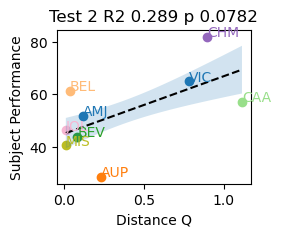

In [66]:
# Correlation avec distance acoustique pour test 2

subjectPerf = []
for ibaby, baby in enumerate(babies):
    subjectPerf.append(np.mean(subjectInfo.loc[subjectInfo['assignedID'] == baby]['success_test2']))


fig, ax = plt.subplots(figsize=(2.5,2), dpi = 100)
# ax.scatter(distancePerf, np.array(subjectPerf)*100.0)

for ibaby, baby in enumerate(babies):
    ax.scatter(distancePerf[ibaby], subjectPerf[ibaby]*100.0, color=cmap.colors[ibaby%20])
    ax.annotate(baby, (distancePerf[ibaby], subjectPerf[ibaby]*100.0), color=cmap.colors[ibaby%20])
    
plt.xlabel('Distance Q')
plt.ylabel('Subject Performance')

# fit a linear curve an estimate its y-values and their error without AUP.
# ind = np.argwhere(np.logical_and(np.isnan(subjectPerf)==False, babies != 'AUP')).flatten()
ind = np.argwhere(np.isnan(subjectPerf)==False).flatten()
x = np.array(distancePerf)[ind]
y = np.array(subjectPerf)[ind]*100.0

xsel, y_est, y_err, r2adj, fval, pval = linefit(x,y)

ax.plot(xsel, y_est, '--', color = 'k')
ax.fill_between(xsel, y_est - y_err, y_est + y_err, alpha=0.2)

ax.set(title='Test 2 R2 %.3f p %.4f' % ( r2adj, pval) )
plt.savefig('/Users/frederictheunissen/Google Drive/My Drive/PowerData/PleursBebe/SubjectvsDistanceTest2.eps')

In [67]:
# fit a linear curve an estimate its y-values and their error without AUP.
ind = np.argwhere(np.logical_and(np.isnan(subjectPerf)==False, babies != 'AUP')).flatten()
x = np.array(distancePerf)[ind]
y = np.array(subjectPerf)[ind]
xsel, y_est, y_err, r2adj, fval, pval = linefit(x,y)
print ('Without AUP: R2 = %.3f p=%.4f' % (r2adj,pval))

Without AUP: R2 = 0.374 p=0.0630


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


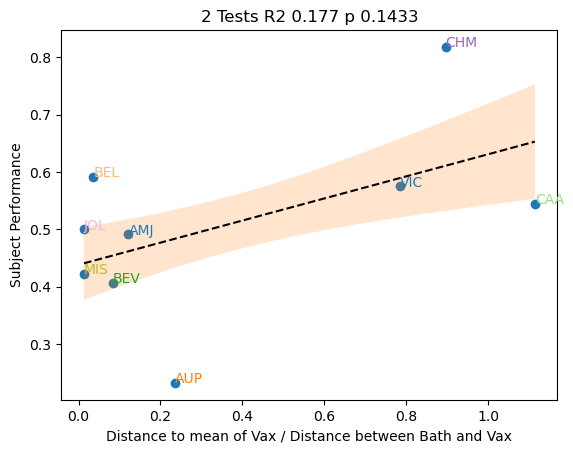

In [68]:
# Correlation avec distance acoustique pour 2 tests

subjectPerf = []
for ibaby, baby in enumerate(babies):
    subjectPerf.append(np.mean(subjectInfo.loc[subjectInfo['assignedID'] == baby]['success_2tests']))

fig, ax = plt.subplots()
ax.scatter(distancePerf, subjectPerf)

for ibaby, baby in enumerate(babies):
    ax.annotate(baby, (distancePerf[ibaby], subjectPerf[ibaby]), color=cmap.colors[ibaby%20])
    
plt.xlabel('Distance to mean of Vax / Distance between Bath and Vax')
plt.ylabel('Subject Performance')

# fit a linear curve an estimate its y-values and their error without AUP.
# ind = np.argwhere(np.logical_and(np.isnan(subjectPerf)==False, babies != 'AUP')).flatten()
ind = np.argwhere(np.isnan(subjectPerf)==False).flatten()
x = np.array(distancePerf)[ind]
y = np.array(subjectPerf)[ind]

xsel, y_est, y_err, r2adj, fval, pval = linefit(x,y)

ax.plot(xsel, y_est, '--', color = 'k')
ax.fill_between(xsel, y_est - y_err, y_est + y_err, alpha=0.2)

ax.set(title='2 Tests R2 %.3f p %.4f' % ( r2adj, pval) )
plt.savefig('/Users/frederictheunissen/Google Drive/My Drive/PowerData/PleursBebe/SubjectvsDistance2Tests.eps')

In [69]:
# fit a linear curve an estimate its y-values and their error without AUP.
ind = np.argwhere(np.logical_and(np.isnan(subjectPerf)==False, babies != 'AUP')).flatten()
x = np.array(distancePerf)[ind]
y = np.array(subjectPerf)[ind]
xsel, y_est, y_err, r2adj, fval, pval = linefit(x,y)
print ('Without AUP: R2 = %.3f p=%.4f' % (r2adj,pval))

Without AUP: R2 = 0.259 p=0.1128


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


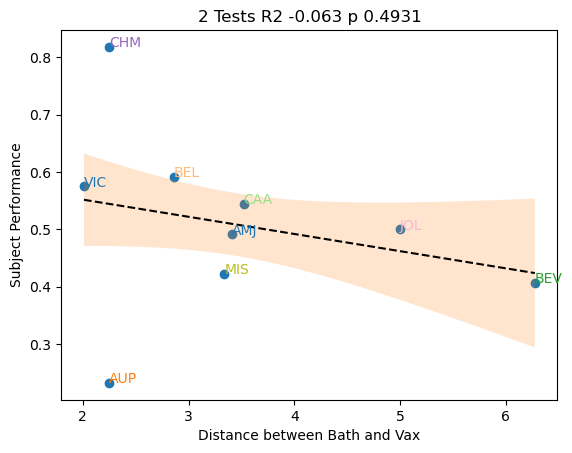

In [70]:
# Correlation avec distance acoustique pour 2 tests

subjectPerf = []
for ibaby, baby in enumerate(babies):
    subjectPerf.append(np.mean(subjectInfo.loc[subjectInfo['assignedID'] == baby]['success_2tests']))

fig, ax = plt.subplots()
ax.scatter(dB2V, subjectPerf)

for ibaby, baby in enumerate(babies):
    ax.annotate(baby, (dB2V[ibaby], subjectPerf[ibaby]), color=cmap.colors[ibaby%20])
    
plt.xlabel('Distance between Bath and Vax')
plt.ylabel('Subject Performance')

# fit a linear curve an estimate its y-values and their error without AUP.
# ind = np.argwhere(np.logical_and(np.isnan(subjectPerf)==False, babies != 'AUP')).flatten()
ind = np.argwhere(np.isnan(subjectPerf)==False).flatten()
x = np.array(dB2V)[ind]
y = np.array(subjectPerf)[ind]

xsel, y_est, y_err, r2adj, fval, pval = linefit(x,y)

ax.plot(xsel, y_est, '--', color = 'k')
ax.fill_between(xsel, y_est - y_err, y_est + y_err, alpha=0.2)

ax.set(title='2 Tests R2 %.3f p %.4f' % ( r2adj, pval) )
plt.savefig('/Users/frederictheunissen/Google Drive/My Drive/PowerData/PleursBebe/SubjectvsDistanceOnly2Tests.eps')